In [1]:
from nldesa import StabilityMap, StabilityMap_Plot
import jax.numpy as jnp
import time
import numpy as np

In [2]:
init_time = time.time()

def system(y, t, a):
    """Equation system of a pendulum."""
    theta, omega = y
    dydt = jnp.asarray([omega, -(a[0] + a[1]*jnp.cos(t))*jnp.sin(theta)])
    return dydt

# Define the initial conditions
y0 = jnp.asarray([jnp.pi - 0.1, 0.0])

# Define the time interval
T_0 = 0.0
T_1 = 100.0
N = 100
component = 0
# Define the parameters

a0 = jnp.linspace(0.2, 0.34, 400)
a1 = jnp.linspace(0.1, 0.24, 400)
a = jnp.asarray([a0, a1])
# First column are the values of a[0], second column are the values of a[1]

if __name__ == '__main__': # Do not remove, to allow multiproessing in windows
    intermediate_time = time.time()
    print(f"Time to define the system: {intermediate_time - init_time}")

    Map = StabilityMap(system, y0, T_0, T_1, N, a, component)



[xla_bridge.py:694 - _suggest_missing_backends() ] An NVIDIA GPU may be present on this machine, but a CUDA-enabled jaxlib is not installed. Falling back to cpu.


Time to define the system: 0.20581293106079102


/home/joaobiu/miniconda3/envs/eqdif-env/lib/python3.11/site-packages/pydmd/utils.py:37: RuntimeWarning: SVD optimal rank is 0. The largest singular values are indistinguishable from noise. Setting rank truncation to 1.
  warnings.warn(
/home/joaobiu/miniconda3/envs/eqdif-env/lib/python3.11/site-packages/pydmd/utils.py:37: RuntimeWarning: SVD optimal rank is 0. The largest singular values are indistinguishable from noise. Setting rank truncation to 1.
  warnings.warn(
/home/joaobiu/miniconda3/envs/eqdif-env/lib/python3.11/site-packages/pydmd/utils.py:37: RuntimeWarning: SVD optimal rank is 0. The largest singular values are indistinguishable from noise. Setting rank truncation to 1.
  warnings.warn(
/home/joaobiu/miniconda3/envs/eqdif-env/lib/python3.11/site-packages/pydmd/utils.py:37: RuntimeWarning: SVD optimal rank is 0. The largest singular values are indistinguishable from noise. Setting rank truncation to 1.
  warnings.warn(
/home/joaobiu/miniconda3/envs/eqdif-env/lib/python3.11/s

[[0.2        0.1        0.        ]
 [0.20035088 0.1        1.        ]
 [0.20070176 0.1        0.        ]
 ...
 [0.33929828 0.24       1.        ]
 [0.3396491  0.24       1.        ]
 [0.34       0.24       0.        ]]


[[0.2        0.1        0.        ]
 [0.20035088 0.1        1.        ]
 [0.20070176 0.1        0.        ]
 ...
 [0.33929828 0.24       1.        ]
 [0.3396491  0.24       1.        ]
 [0.34       0.24       0.        ]]
(160000, 3)


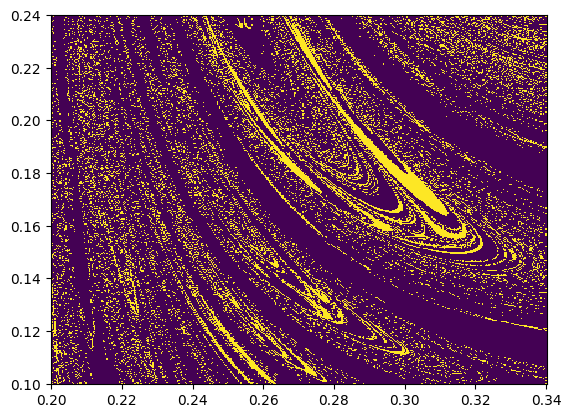

In [18]:
print(Map)
print(Map.shape)
StabilityMap_Plot(Map)

In [19]:
# Separate into [x0, x1, y] into X = (x0, x1) and Y = y
X = Map[:, :-1]
Y = Map[:, -1]

# Transform the data into a numpy array
X = np.array(X)
Y = np.array(Y)

In [20]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [21]:
X = torch.from_numpy(X).float()
Y = torch.tensor(Y.reshape((X.shape[0], 1)),dtype=torch.float)

In [22]:
print(f"Shape of X: {X.shape}")
print(f"Shape of Y: {Y.shape}")

Shape of X: torch.Size([160000, 2])
Shape of Y: torch.Size([160000, 1])


In [23]:
n_features = X.shape[1]

In [24]:
# Separate into training and test data
train_size = int(0.8 * X.shape[0])
test_size = X.shape[0] - train_size

X_train = X[:train_size]
X_test = X[train_size:]
Y_train = Y[:train_size]
Y_test = Y[train_size:]
print(f"Shape of X_train: {X_train.shape}")
print(f"Shape of X_test: {X_test.shape}")
print(f"Shape of Y_train: {Y_train.shape}")
print(f"Shape of Y_test: {Y_test.shape}")

Shape of X_train: torch.Size([128000, 2])
Shape of X_test: torch.Size([32000, 2])
Shape of Y_train: torch.Size([128000, 1])
Shape of Y_test: torch.Size([32000, 1])


In [25]:
# Define the network
class SimpleNN(nn.Module):
    def __init__(self):
        super(SimpleNN, self).__init__()
        self.fc = nn.Linear(2, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.fc(x)
        x = self.sigmoid(x)
        return x


In [26]:
model = SimpleNN()
loss_fn = nn.BCELoss()
optimizer = optim.SGD(model.parameters(), lr=0.01)

In [27]:
def train(model, X, y, epochs=100):
    """
        Defining the training loop. 
    """
    model.train()  # <-- here
    loss_history = []
    for _ in range(epochs):
        optimizer.zero_grad() # sets the gradients "to zero".

        y_ = model(X)
        loss = loss_fn(y_, y)
        
        loss_history.append(loss.item())

        loss.backward() # computes the gradients.
        optimizer.step() # updates weights using the gradients.

    return loss_history

In [28]:
def evaluate(model, X):
    """
        Evaluating the model. 
    """
    model.eval()  # <-- here
    with torch.no_grad(): 
        y_ = model(X)    
    return y_

In [29]:
def accuracy(y, y_hat):
    """
        Accuracy of the model. 
    """
    print(y.shape)
    return np.mean((y == y_hat).numpy())

In [30]:
loss_history = train(model, X_train, Y_train, epochs=100)
y_hat = evaluate(model, X_test)

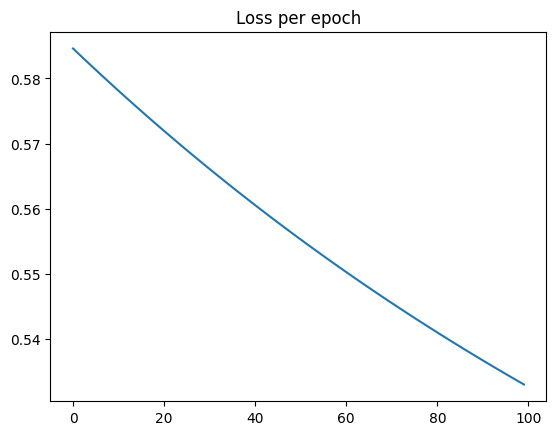

In [31]:
import matplotlib.pyplot as plt
plt.plot(loss_history)
plt.title('Loss per epoch');

In [32]:
for i in range(len(y_hat)):
    if y_hat[i] > 0.5:
        y_hat[i] = 1
    else:
        y_hat[i] = 0
[print(y_hat[j]) for j in range(len(y_hat)) if y_hat[j] == 1]

[]